In [1]:
# computational libraries
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

# plotting libraries
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# preprocessing
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

This cell constructs a DataFrame called X that contains the covariate data. Here, one-hot dates, weather lag, and electricity lag features are added for a total of 45 covariates.

In [3]:
# create X as a copy of y
X = pd.DataFrame(index=y.index)

# add electricity lag features (be careful with this)
# elec = pd.DataFrame(index=y.index)
# for i in range(1,7):
#     elec['elec -'+str(i)] = np.append(np.array([np.nan]*i),y.values[0:len(y)-i])
# X = X.join(elec)

# add weather lag features
weather = pd.read_csv('../data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')
weather = weather.loc[y.index[0]:y.index[len(y)-1]]
X = X.join(weather)

# add boolean date features
dates = pd.read_csv('../data/one_hot_dates.csv',index_col=0)
dates.index = pd.to_datetime(dates.index,format='%Y-%m-%d %H:00:00')
X = X.join(dates)

# truncate y and X to match each other (this step is only necessary if using elec lag features)
X = X.iloc[6:]
y = y.iloc[6:]

This cell defines the train and test sets for a random day in the dataset.

In [5]:
# choose a random day between Jan 10 and July 10 to test
split_times = pd.date_range(start='2018-01-10 08:00:00',end='2018-07-10 08:00:00',freq='D')
split_time = split_times[np.random.randint(len(split_times))]
end_time = split_time + pd.DateOffset(hours=39)

# define train set before the split and test the following day
X_train = X.loc[X.index <= split_time].copy()
X_test = X.loc[(X.index > split_time) & (X.index <= end_time)].copy()
y_train = y.loc[y.index <= split_time].copy()
y_test = y.loc[(y.index > split_time) & (y.index <= end_time)].copy()

# fit standard scalers to the weather and elec features in the training data
weather_fit = StandardScaler().fit(X_train[weather.columns])
# elec_fit = StandardScaler().fit(X_train[elec.columns])

# scale the training and test sets using the scalers fit to the training set
X_train[weather.columns] = weather_fit.transform(X_train[weather.columns])
# X_train[elec.columns] = elec_fit.fit_transform(X_train[elec.columns])
X_test[weather.columns] = weather_fit.transform(X_test[weather.columns])
# X_test[elec.columns] = elec_fit.transform(X_test[elec.columns])

Now the training and test sets are fully defined. The next cell trains a linear model and makes a prediction.

In [6]:
# define the models to be used, all off-the-shelf right now (no tuned parameters)
models = [LinearRegression(),
          LinearSVR(),
          DecisionTreeRegressor(),
          XGBRegressor()
         ]

mapes = pd.DataFrame(columns=['model','mape'])
results = pd.DataFrame(y_test,columns=['Actual'])                  
count = 0

for k in models:
    reg = k.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))*100
    
    count = count+1
    mapes = mapes.append({'model':count,'mape':mape},ignore_index=True)
    results[count] = y_pred

mapes

,model,mape
0,1.0,10.335203
1,2.0,26.906347
2,3.0,16.187998
3,4.0,13.594286


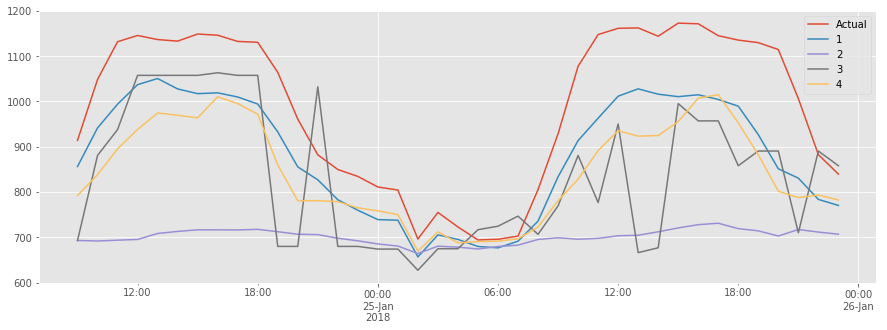

In [7]:
results.plot(figsize=(15, 5))